# Build per-arm bandit with `EncodingNetwork` 

## Notes

### references

**TF-Agent tutorials:**

(1) [Multi-Armed Bandits with Per-Arm Features](https://www.tensorflow.org/agents/tutorials/per_arm_bandits_tutorial)

* step-by-step guide on how to use the TF-Agents library for contextual bandits problems where the actions (arms) have their own features, such as a list of movies represented by features (genre, year of release, ...)

(2) [Networks](https://www.tensorflow.org/agents/tutorials/8_networks_tutorial)

* define custom networks for your agents
* The networks help us define the model that is trained by agents

(3) [Ranking](https://www.tensorflow.org/agents/tutorials/ranking_tutorial)

* ranking algorithms implemented as part of the TF-Agents Bandits library 
* In a ranking problem, in every iteration an agent is presented with a set of items, and is tasked with ranking some or all of them to a list
* This ranking decision then receives some form of feedback (maybe a user does or does not click on one or more of the selected items for example)
* The goal of the agent is to optimize some metric/reward with the goal of making better decisions over time

### background

**Arm features**
* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

# setup notebook environment

In [1]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.26.0


## Load env config

* use the prefix from `00-env-setup`

In [2]:
PREFIX = 'mabv1'

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "mabv1"
VERSION                  = "v1"

BUCKET_NAME              = "mabv1-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://mabv1-hybrid-vertex-bucket/data"
BUCKET_URI               = "gs://mabv1-hybrid-vertex-bucket"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_ID      = "hybrid-vertex.movielens_dataset_mabv1"
BIGQUERY_TABLE_ID        = "hybrid-vertex.movielens_dataset_mabv1.training_dataset"

REPO_DOCKER_PATH_PREFIX  = "src"
RL_SUB_DIR               = "per_arm_rl"



In [4]:
# ! gsutil ls $BUCKET_URI

## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

# logging
import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent

# GPU
from numba import cuda 
import gc

# my project
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

### detect GPUs & reset devices

In [8]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
# gpus

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

### Initialize Google Cloud SDK Clients

In [11]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Read TF Records

In [12]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [13]:
train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/val'): # tmp TODO - "train"
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://mabv1-hybrid-vertex-bucket/data/val/ml-ratings-100k-val.tfrecord']

In [14]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([25.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[4]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'211'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([874948475])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'346'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'other'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


### get vocab

**TODO:** 
* streamline vocab calls

In [21]:
GENERATE_VOCABS = False
print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

VOCAB_SUBDIR   = "vocabs"
VOCAB_FILENAME = "vocab_dict.pkl"

GENERATE_VOCABS: False


In [22]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://mabv1-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


# Per-Arm Bandits

In [15]:
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

nest = tf.nest

## define preprocessing layers for global and arm features

The preproccesing layers will ultimately feed the two functions described below, both of which will ultimately feed the `Environment`

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). * This output is the per-arm context. Its shape must be consistent across calls.

In [16]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 4
MV_EMBEDDING_SIZE      = 8 #32

### global preprcoessing layers

In [19]:
# global_inputs = []
# global_features = []

#### user ID

In [23]:
user_id_input_layer = tf.keras.Input(
    name="user_id",
    shape=(1,),
    dtype=tf.string
)

user_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_id'],
)(user_id_input_layer)

user_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_id']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_id_lookup)

user_id_embedding = tf.reduce_sum(user_id_embedding, axis=-2)

# global_inputs.append(user_id_input_layer)
# global_features.append(user_id_embedding)

In [31]:
test_user_id_model = tf.keras.Model(inputs=user_id_input_layer, outputs=user_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_id"])
    print(test_user_id_model(x["user_id"]))

tf.Tensor([b'346'], shape=(1,), dtype=string)
tf.Tensor([[-0.02583126 -0.04207677 -0.03458632  0.0164226 ]], shape=(1, 4), dtype=float32)


#### user AGE

In [33]:
user_age_input_layer = tf.keras.Input(
    name="bucketized_user_age",
    shape=(1,),
    dtype=tf.float32
)

user_age_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['bucketized_user_age'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(user_age_input_layer)

user_age_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['bucketized_user_age']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_age_lookup)

user_age_embedding = tf.reduce_sum(user_age_embedding, axis=-2)

# global_inputs.append(user_age_input_layer)
# global_features.append(user_age_embedding)

In [35]:
test_user_age_model = tf.keras.Model(inputs=user_age_input_layer, outputs=user_age_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["bucketized_user_age"])
    print(test_user_age_model(x["bucketized_user_age"]))

tf.Tensor([25.], shape=(1,), dtype=float32)
tf.Tensor([[ 0.00287176  0.04646393 -0.03537762 -0.04847401]], shape=(1, 4), dtype=float32)


#### user OCC

In [34]:
user_occ_input_layer = tf.keras.Input(
    name="user_occupation_text",
    shape=(1,),
    dtype=tf.string
)

user_occ_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['user_occupation_text'],
)(user_occ_input_layer)

user_occ_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['user_occupation_text']) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_occ_lookup)

user_occ_embedding = tf.reduce_sum(user_occ_embedding, axis=-2)

# global_inputs.append(user_occ_input_layer)
# global_features.append(user_occ_embedding)

In [36]:
test_user_occ_model = tf.keras.Model(inputs=user_occ_input_layer, outputs=user_occ_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["user_occupation_text"])
    print(test_user_occ_model(x["user_occupation_text"]))

tf.Tensor([b'other'], shape=(1,), dtype=string)
tf.Tensor([[-0.02817255  0.02386321  0.00724526  0.03607016]], shape=(1, 4), dtype=float32)


#### user Timestamp

In [37]:
user_ts_input_layer = tf.keras.Input(
    name="timestamp",
    shape=(1,),
    dtype=tf.int64
)

user_ts_lookup = tf.keras.layers.Discretization(
    vocab_dict['timestamp_buckets'].tolist()
)(user_ts_input_layer)

user_ts_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['timestamp_buckets'].tolist()) + NUM_OOV_BUCKETS,
    output_dim=GLOBAL_EMBEDDING_SIZE
)(user_ts_lookup)

user_ts_embedding = tf.reduce_sum(user_ts_embedding, axis=-2)

# global_inputs.append(user_ts_input_layer)
# global_features.append(user_ts_embedding)

In [38]:
test_user_ts_model = tf.keras.Model(inputs=user_ts_input_layer, outputs=user_ts_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["timestamp"])
    print(test_user_ts_model(x["timestamp"]))

tf.Tensor([874948475], shape=(1,), dtype=int64)
tf.Tensor([[-0.01595841  0.04967744 -0.04279407 -0.01032622]], shape=(1, 4), dtype=float32)


### create `global_context_sampling_fn()`

In [126]:
def global_context_sampling_fn():
    """
    This function generates a single global observation vector.
    """
    # for x in train_dataset.take(1).as_numpy_iterator():
    for x in train_dataset.batch(1).take(1):
        user_id_value = x['user_id']
        user_age_value = x['bucketized_user_age']
        user_occ_value = x['user_occupation_text']
        user_ts_value = x['timestamp']
        
        _id = test_user_id_model(user_id_value)
        _age = test_user_age_model(user_age_value)
        _occ = test_user_occ_model(user_occ_value)
        _ts = test_user_ts_model(user_ts_value)
        
        # # tmp - insepct numpy() values
        # print(_id.numpy()) #[0])
        # print(_age.numpy()) #[0])
        # print(_occ.numpy()) #[0])
        # print(_ts.numpy()) #[0])
        
        # to numpy array
        _id = np.array(_id.numpy()[0])
        _age = np.array(_age.numpy()[0])
        _occ = np.array(_occ.numpy()[0])
        _ts = np.array(_ts.numpy()[0])
        
        concat = np.concatenate(
            [_id, _age, _occ, _ts], axis=-1
        ).astype(np.float32)
        
        return concat

In [127]:
global_context_sampling_fn()

<class 'numpy.ndarray'>


array([-0.02583126, -0.04207677, -0.03458632,  0.0164226 ,  0.00287176,
        0.04646393, -0.03537762, -0.04847401, -0.02817255,  0.02386321,
        0.00724526,  0.03607016, -0.01595841,  0.04967744, -0.04279407,
       -0.01032622], dtype=float32)

In [51]:
GLOBAL_DIM = 40
GLOBAL_BOUND = 10

def test_global_context_sampling_fn():
    """This function generates a single global observation vector."""
    return np.random.randint(
      -GLOBAL_BOUND, GLOBAL_BOUND, [GLOBAL_DIM]).astype(np.float32)

In [52]:
test_global_context_sampling_fn()

array([ -1.,   9.,   0.,  -6.,  -7.,  -9.,  -8.,  -8.,   1., -10.,  -8.,
         0.,  -7.,  -5.,  -2.,  -1.,  -1.,   2.,   9.,  -8.,   1.,   5.,
         3.,  -8.,  -3.,   3.,  -5.,  -2.,   4.,  -6.,   6.,  -9.,   3.,
         1., -10.,  -5.,   6.,  -5.,  -3.,  -9.], dtype=float32)

### arm preprocessing layers

#### movie ID

In [129]:
mv_id_input_layer = tf.keras.Input(
    name="movie_id",
    shape=(1,),
    dtype=tf.string
)

mv_id_lookup = tf.keras.layers.StringLookup(
    max_tokens=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    num_oov_indices=NUM_OOV_BUCKETS,
    mask_token=None,
    vocabulary=vocab_dict['movie_id'],
)(mv_id_input_layer)

mv_id_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_id']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_id_lookup)

mv_id_embedding = tf.reduce_sum(mv_id_embedding, axis=-2)

# arm_inputs.append(mv_id_input_layer)
# arm_features.append(mv_id_embedding)

In [130]:
test_mv_id_model = tf.keras.Model(inputs=mv_id_input_layer, outputs=mv_id_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_id"])
    print(test_mv_id_model(x["movie_id"]))

tf.Tensor([b'211'], shape=(1,), dtype=string)
tf.Tensor(
[[-0.04766324  0.04516241 -0.03255399 -0.04533198 -0.04379729  0.0467107
  -0.00805283  0.02642926]], shape=(1, 8), dtype=float32)


#### movie genre

In [131]:
mv_genre_input_layer = tf.keras.Input(
    name="movie_genres",
    shape=(1,),
    dtype=tf.float32
)

mv_genre_lookup = tf.keras.layers.IntegerLookup(
    vocabulary=vocab_dict['movie_genres'],
    num_oov_indices=NUM_OOV_BUCKETS,
    oov_value=0,
)(mv_genre_input_layer)

mv_genre_embedding = tf.keras.layers.Embedding(
    # Let's use the explicit vocabulary lookup.
    input_dim=len(vocab_dict['movie_genres']) + NUM_OOV_BUCKETS,
    output_dim=MV_EMBEDDING_SIZE
)(mv_genre_lookup)

mv_genre_embedding = tf.reduce_sum(mv_genre_embedding, axis=-2)

# arm_inputs.append(mv_genre_input_layer)
# arm_features.append(mv_genre_embedding)

In [132]:
test_mv_gen_model = tf.keras.Model(inputs=mv_genre_input_layer, outputs=mv_genre_embedding)

for x in train_dataset.batch(1).take(1):
    print(x["movie_genres"])
    print(test_mv_gen_model(x["movie_genres"]))

tf.Tensor([[4]], shape=(1, 1), dtype=int64)
tf.Tensor(
[[-0.0385772   0.0493708  -0.00875748  0.00334692  0.01747172  0.04738164
   0.00484369 -0.0458091 ]], shape=(1, 8), dtype=float32)


### create `arm_context_sampling_fn()`

In [145]:
def per_arm_context_sampling_fn():
    """
    This function generates a single per-arm observation vector
    """
    for x in train_dataset.batch(1).take(1):
        mv_id_value = x['movie_id']
        mv_gen_value = x['movie_genres'][0]
        
        _mid = test_mv_id_model(mv_id_value)
        _mgen = test_mv_gen_model(mv_gen_value)
        
        # to numpy array
        _mid = np.array(_mid.numpy()[0])
        _mgen = np.array(_mgen.numpy()[0])
        
        # print(_mid)
        # print(_mgen)
        
        concat = np.concatenate([_mid, _mgen], axis=-1).astype(np.float32)
        
        return concat

In [146]:
per_arm_context_sampling_fn()

array([-0.04766324,  0.04516241, -0.03255399, -0.04533198, -0.04379729,
        0.0467107 , -0.00805283,  0.02642926, -0.0385772 ,  0.0493708 ,
       -0.00875748,  0.00334692,  0.01747172,  0.04738164,  0.00484369,
       -0.0458091 ], dtype=float32)

## define reward function

In [152]:
GLOBAL_DIM = global_context_sampling_fn()
GLOBAL_DIM = GLOBAL_DIM.shape[0]
print(GLOBAL_DIM)

PER_ARM_DIM = per_arm_context_sampling_fn()
PER_ARM_DIM = PER_ARM_DIM.shape[0]
print(PER_ARM_DIM)

16
16


In [269]:
PARAM_BOUND = 10 

# should be similar to
reward_param = list(np.random.randint(-PARAM_BOUND, PARAM_BOUND, [GLOBAL_DIM + PER_ARM_DIM]))
# reward_param

In [165]:
len(reward_param)

32

In [ ]:
test_global_out = global_context_sampling_fn()
test_arm_out = per_arm_context_sampling_fn()

x_x = np.concatenate([test_global_out, test_arm_out], axis=-1)
# x_x
mu = np.dot(x_x, reward_param)
mu

1.1144518535584211

In [168]:
VARIANCE = 100.0 

def linear_normal_reward_fn(x):
    """This function generates a reward from the concatenated global and per-arm observations."""
    mu = np.dot(x, reward_param)
    return np.random.normal(mu, VARIANCE)

In [169]:
linear_normal_reward_fn(x_x)

113.71864410600686

In [154]:
# def _get_rewards(element):
#     """Calculates reward for the actions."""

#     def _calc_reward(x):
#         """Calculates reward for a single action."""
#         r0 = lambda: tf.constant(0.0)
#         r1 = lambda: tf.constant(-10.0)
#         r2 = lambda: tf.constant(2.0)
#         r3 = lambda: tf.constant(3.0)
#         r4 = lambda: tf.constant(4.0)
#         r5 = lambda: tf.constant(10.0)
#         c1 = tf.equal(x, 1.0)
#         c2 = tf.equal(x, 2.0)
#         c3 = tf.equal(x, 3.0)
#         c4 = tf.equal(x, 4.0)
#         c5 = tf.equal(x, 5.0)
#         return tf.case([(c1, r1), (c2, r2), (c3, r3),(c4, r4),(c5, r5)], default=r0, exclusive=True)

#     return tf.map_fn(
#         fn=_calc_reward, 
#         elems=element['user_rating'], 
#         dtype=tf.float32
#     )

In [268]:
# for x in train_dataset.batch(1).take(3):
#     print(f"Rating: {x['user_rating']}")
#     print(f"Reward: {_get_rewards(x)}") #["user_rating"]))

### output ####
# Rating: [4.]
# Reward: [4.]
# Rating: [4.]
# Reward: [4.]
# Rating: [1.]
# Reward: [-10.]

## define environment

In [239]:
NUM_ACTIONS = 10
BATCH_SIZE = 8

In [240]:
per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn,
    per_arm_context_sampling_fn,
    NUM_ACTIONS,
    linear_normal_reward_fn, # _get_rewards
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

In [241]:
print('observation spec: ', per_arm_tf_env.observation_spec())

observation spec:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None)}


In [242]:
print('\nAn observation: ', per_arm_tf_env.reset().observation)


An observation:  {'global': <tf.Tensor: shape=(8, 16), dtype=float32, numpy=
array([[-0.02583126, -0.04207677, -0.03458632,  0.0164226 ,  0.00287176,
         0.04646393, -0.03537762, -0.04847401, -0.02817255,  0.02386321,
         0.00724526,  0.03607016, -0.01595841,  0.04967744, -0.04279407,
        -0.01032622],
       [-0.02583126, -0.04207677, -0.03458632,  0.0164226 ,  0.00287176,
         0.04646393, -0.03537762, -0.04847401, -0.02817255,  0.02386321,
         0.00724526,  0.03607016, -0.01595841,  0.04967744, -0.04279407,
        -0.01032622],
       [-0.02583126, -0.04207677, -0.03458632,  0.0164226 ,  0.00287176,
         0.04646393, -0.03537762, -0.04847401, -0.02817255,  0.02386321,
         0.00724526,  0.03607016, -0.01595841,  0.04967744, -0.04279407,
        -0.01032622],
       [-0.02583126, -0.04207677, -0.03458632,  0.0164226 ,  0.00287176,
         0.04646393, -0.03537762, -0.04847401, -0.02817255,  0.02386321,
         0.00724526,  0.03607016, -0.01595841,  0.049

In [243]:
action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)


Rewards after taking an action:  tf.Tensor(
[  24.199184    62.48732   -132.08417    131.18488      1.3451474
  -50.468956   -42.02937     35.61168  ], shape=(8,), dtype=float32)


In [244]:
observation_spec = per_arm_tf_env.observation_spec()
time_step_spec = ts.time_step_spec(observation_spec)
# time_step_spec

In [245]:
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=NUM_ACTIONS - 1)

# action_spec

In [246]:
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec=time_step_spec,
    action_spec=action_spec,
    accepts_per_arm_features=True
)

# agent

## The flow of training data

In [247]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [248]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None)}


In [249]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(16,), dtype=tf.float32, name=None)


## Defining the Regret Metric

In [250]:
def _all_rewards(observation, hidden_param):
    """Outputs rewards for all actions, given an observation."""
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation['global']
    per_arm_obs = observation['per_arm']
    num_actions = tf.shape(per_arm_obs)[1]
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1), [1, num_actions, 1])
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation):
    """Outputs the maximum expected reward for every element in the batch."""
    return tf.reduce_max(_all_rewards(observation, reward_param), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)
regret_metric

## Training Loop

* train stationary env [example](https://github.com/418sec/agents/blob/master/tf_agents/bandits/agents/examples/v2/train_eval_per_arm_stationary_linear.py)
* train loop [src](https://github.com/418sec/agents/blob/master/tf_agents/bandits/agents/examples/v2/trainer.py)


**TODO**
* add checkpointer
* add ditribution strategy (GPU support)

In [277]:
from tf_agents.bandits.agents.examples.v2 import trainer

In [278]:
EXPERIMENT_NAME   = f'linear-bandit-v1'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

LOG_DIR           = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/tb-logs"
ROOT_DIR          = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : linear-bandit-v1
RUN_NAME          : run-20230727-224130
LOG_DIR           : gs://mabv1-hybrid-vertex-bucket/linear-bandit-v1/run-20230727-224130/tb-logs
ROOT_DIR          : gs://mabv1-hybrid-vertex-bucket/linear-bandit-v1/run-20230727-224130/root
ARTIFACTS_DIR     : gs://mabv1-hybrid-vertex-bucket/linear-bandit-v1/run-20230727-224130/artifacts


In [279]:
import tensorflow as tf
from src.per_arm_rl import trainer_common_v7 as trainer_common

TRAINING_LOOPS = 200
STEPS_PER_LOOP = 2
drop_arm_feature_fn = None

In [280]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP
)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=agent.collect_policy,
    num_steps=STEPS_PER_LOOP * BATCH_SIZE,
    observers=observers
)

In [ ]:
#start the timer and training
start_time = time.time()

metric_results, regret_values = trainer_common.train_perarm(
    agent = agent,
    replay_buffer = replay_buffer,
    driver = driver,
    environment = per_arm_tf_env,
    num_iterations = TRAINING_LOOPS,
    steps_per_loop = STEPS_PER_LOOP,
    log_interval = 1,
    regret_metric = regret_metric,
    additional_metrics = [regret_metric],
    log_dir=LOG_DIR,
    model_dir=ARTIFACTS_DIR
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

starting train loop...
step = 0: loss = 11688.7802734375; execution time: 0


### log experiment to Vertex

In [272]:
float(metric_results["RegretMetric"][-1])

3.812655448913574

In [276]:
aiplatform.start_run(
    RUN_NAME
    # , tensorboard=TB_RESOURCE_NAME
    , resume=False
)

aiplatform.log_params(
    {
        "runtime": runtime_mins,
        "batch_size": BATCH_SIZE, 
        "training_loops": TRAINING_LOOPS,
        "steps_pre_loop": STEPS_PER_LOOP,
        # "rank_k": RANK_K,
        "num_actions": NUM_ACTIONS,
        "per_arm": "True",
    }
)

# gather the metrics for the last epoch to be saved in metrics
aiplatform.log_metrics(
    {
        "AverageReturnMetric" : float(metric_results["AverageReturnMetric"][-1])
        , "FinalRegretMetric" : float(metric_results["RegretMetric"][-1])
    }
)

aiplatform.end_run()

### bandit eval

In [274]:
# metric_results

In [259]:
for key in metric_results:
    print(key)

NumberOfEpisodes
AverageEpisodeLengthMetric
AverageReturnMetric
RegretMetric


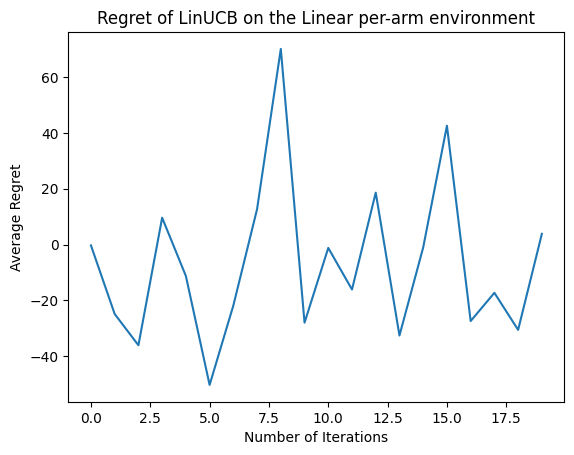

In [267]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

In [260]:
def plot(metric_results, metric_name):
    plt.plot(metric_results[metric_name])
    plt.ylabel(metric_name)
    plt.xlabel("Step")
    plt.title("{} versus Step".format(metric_name))

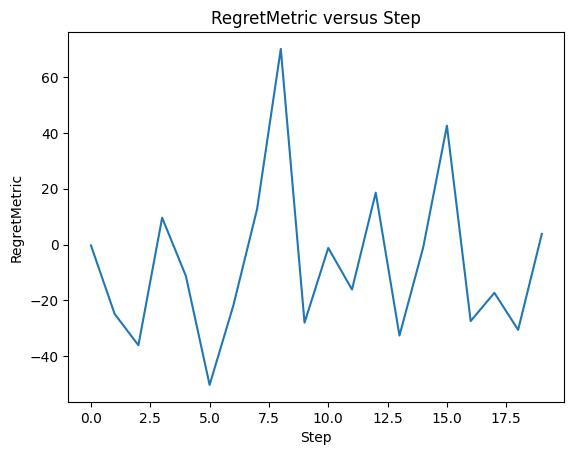

In [261]:
plot(metric_results, "RegretMetric")

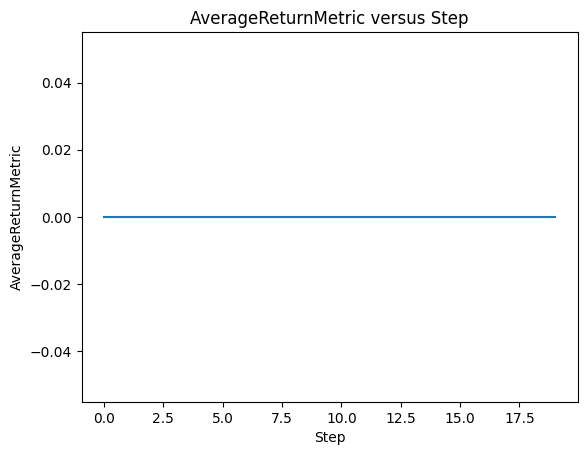

In [262]:
plot(metric_results, "AverageReturnMetric")

#### TensorBoard

In [263]:
%load_ext tensorboard
# %reload_ext tensorboard

In [264]:
%tensorboard --logdir=$LOG_DIR

# Neural Bandits

* `ActorNetwork` and `EncodingNetwork`

In [200]:
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.networks import global_and_arm_feature_network

In [201]:
LAYERS = [16, 4]
LR = 0.05
EPSILON = 0.02

In [202]:
network = (
    global_and_arm_feature_network.create_feed_forward_dot_product_network(
        per_arm_tf_env.time_step_spec().observation,
        global_layers=LAYERS,
        arm_layers=LAYERS
    )
)

In [203]:
eps_agent = eps_greedy_agent.NeuralEpsilonGreedyAgent(
    time_step_spec=per_arm_tf_env.time_step_spec(),
    action_spec=per_arm_tf_env.action_spec(),
    reward_network=network,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
    epsilon=EPSILON,
    emit_policy_info='predicted_rewards_mean',
    info_fields_to_inherit_from_greedy=['predicted_rewards_mean']
)

In [210]:
print('training data spec: ', eps_agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(9, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None)}),
 'policy_info': PolicyInfo(log_probability=(), predicted_rewards_mean=TensorSpec(shape=(10,), dtype=tf.float32, name=None), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [211]:
print('observation spec in training: ', eps_agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(16,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(10, 16), dtype=tf.float32, name=None)}


In [213]:
# print('chosen arm features: ', eps_agent.training_data_spec.policy_info.chosen_arm_features)

In [214]:
TRAINING_LOOPS=10
STEPS_PER_LOOP=1

In [215]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=eps_agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=eps_agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers
)

regret_values = []

#start the timer and training
start_time = time.time()

for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = eps_agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())
    
end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"complete train job in {runtime_mins} minutes")

complete train job in 1 minutes


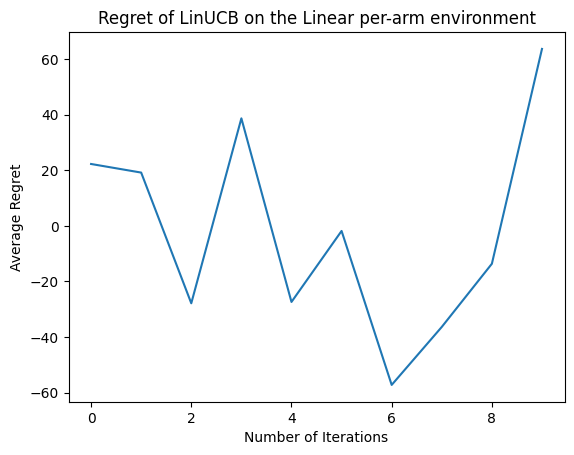

In [216]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

#### TODO

In [ ]:
# elif FLAGS.agent == 'NeuralLinUCB':
# obs_spec = environment.observation_spec()
# network = (
#     global_and_arm_feature_network.create_feed_forward_common_tower_network(
#         obs_spec, (40, 30), (30, 40), (40, 20), ENCODING_DIM
#     )
# )
# agent = neural_linucb_agent.NeuralLinUCBAgent(
#     time_step_spec=environment.time_step_spec(),
#     action_spec=environment.action_spec(),
#     encoding_network=network,
#     encoding_network_num_train_steps=EPS_PHASE_STEPS,
#     encoding_dim=ENCODING_DIM,
#     optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
#     alpha=1.0,
#     gamma=1.0,
#     epsilon_greedy=EPSILON,
#     accepts_per_arm_features=True,
#     debug_summaries=True,
#     summarize_grads_and_vars=True,
#     emit_policy_info=policy_utilities.InfoFields.PREDICTED_REWARDS_MEAN,
# )